In [57]:
# Import Libraries
import numpy as np 
import pandas as pd 
import time
import itertools

# file system libraries
import os
import os.path
from   os import path
import shutil

# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Images, Plotting
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# tensorflow - CNNs
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, Sequential
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121,InceptionV3, Xception, ResNet101
from kerastuner.tuners import Hyperband

## Dataset Maker

In [58]:
case = 'demted'
flag = False
if case == 'demted':
    flag = True

In [59]:
if not flag:
    print('train dataset loaded')
    train_dataset = tf.data.Dataset.list_files('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/NonDemented/*.jpg')

In [60]:
if flag:
    print('train dataset is loading')
    dirs = ['../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented',
           '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/ModerateDemented',
           '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/VeryMildDemented']
    
    all_file_paths = []
    
    for cur_dir in dirs:
        file_names = os.listdir(cur_dir)
        file_paths = [os.path.join(cur_dir,file_name) for file_name in file_names]
        all_file_paths += file_paths
    print(f'total files {len(all_file_paths)}')
    train_dataset = tf.data.Dataset.from_tensor_slices(all_file_paths)
    print('train dataset loaded')

train dataset is loading
total files 2561
train dataset loaded


In [61]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [128,128])
    image /= 255.0  # normalize to [0,1] range
    return image
train_dataset = train_dataset.map(load_and_preprocess_image)
batch_size = 16
train_dataset = train_dataset.shuffle(10 * batch_size).batch(batch_size, drop_remainder=True).prefetch(buffer_size=50)

In [62]:
for idx,temp in enumerate(train_dataset):
    continue
steps_per_epoch = idx+1
standard = 100 * 160
epochs = standard // steps_per_epoch
steps_per_epoch, epochs

(160, 100)

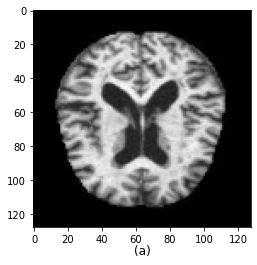

In [63]:
plt.imshow(temp[1],cmap='gray')
plt.title('(a)',y=-0.155)
plt.savefig('original_image_1.png',dpi=300)

In [64]:
temp.shape

TensorShape([16, 128, 128, 1])

## Training

In [65]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [66]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [67]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 64)   18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 65536)        0           conv2d_7[0][0]                   
____________________________________________________________________________________________

In [68]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 65536)             720896    
_________________________________________________________________
reshape_3 (Reshape)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 128, 128, 32)      18464     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 128, 128, 1)       289       
Total params: 776,577
Trainable params: 776,577
Non-trainable params: 0
_____________________________________________________

In [69]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [70]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(train_dataset, epochs=100)

Epoch 1/100
160/160 [==============================] - 3s 12ms/step - loss: 7125.0985 - reconstruction_loss: 6115.3911 - kl_loss: 37.1887
Epoch 2/100
160/160 [==============================] - 2s 12ms/step - loss: 5626.8369 - reconstruction_loss: 5592.6094 - kl_loss: 15.0575
Epoch 3/100
160/160 [==============================] - 2s 12ms/step - loss: 5509.0924 - reconstruction_loss: 5444.1299 - kl_loss: 15.8480
Epoch 4/100
160/160 [==============================] - 2s 12ms/step - loss: 5270.6526 - reconstruction_loss: 5228.8838 - kl_loss: 20.4309
Epoch 5/100
160/160 [==============================] - 2s 12ms/step - loss: 5220.0803 - reconstruction_loss: 5186.4912 - kl_loss: 20.7604
Epoch 6/100
160/160 [==============================] - 2s 12ms/step - loss: 5200.7893 - reconstruction_loss: 5171.0049 - kl_loss: 20.0496
Epoch 7/100
160/160 [==============================] - 2s 12ms/step - loss: 5190.1023 - reconstruction_loss: 5163.0869 - kl_loss: 19.6719
Epoch 8/100
160/160 [=============

In [76]:

for idx,temp in enumerate(train_dataset):
    
    if idx == 0:
        images = np.copy(temp)
        continue
    images = np.concatenate((images,temp))

In [77]:
_,_,predicted = vae.encoder.predict(images)

In [78]:
predicted = vae.decoder.predict(predicted)

In [79]:
from sklearn.utils import shuffle 

predicted = shuffle(predicted)
predicted = shuffle(predicted)

np.save('VAE-Dementia-images.npy',predicted[:1000])

In [80]:
predicted.shape

(2560, 128, 128, 1)

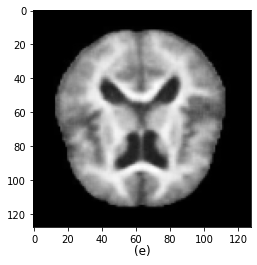

In [81]:
plt.imshow(predicted[15],cmap='gray')
plt.title('(e)',y=-0.155)
plt.savefig('vae_image.png',dpi=300)